In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import cmdstan_path, CmdStanModel
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import arviz as az
import statsmodels.api as sm
import tqdm

from datamodel import SPX, StockData
from model_testing import create_lags, BayesModel, BayesTimeSeriesCrossVal

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
spx = SPX()
vix_data = StockData(["^VIX"])

In [41]:
spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
vix_wk_prices = vix_data.prices.VIX["close"].resample("W-FRI").last()
spx_wk_vol = np.sqrt(spx.vol.resample("W-FRI").sum())

wk_returns_lags = create_lags(spx_wk_returns, 4, "wk_returns")
wk_vix_lags = create_lags(vix_wk_prices, 4, "wk_vix")
wk_vol_lags = create_lags(spx_wk_vol, 4, "wk_vol")

d_spx_returns = (np.log(spx.prices) - np.log(spx.prices.shift(1))).dropna()
d_returns_lags = create_lags(d_spx_returns, 21, "d_returns")
d_vix_lags = create_lags(vix_data.prices.VIX["close"], 21, "d_vix")
d_vol_lags = create_lags(np.sqrt(spx.vol), 21, "d_vol")

x = pd.concat([wk_returns_lags, np.log(wk_vix_lags), np.log(wk_vol_lags), d_returns_lags, np.log(d_vix_lags), np.log(d_vol_lags)], axis=1).dropna()
y = np.log(spx_wk_vol).shift(-1).dropna()

common_index = x.index.intersection(y.index)
x = x.loc[common_index]
y = y.loc[common_index]

In [ ]:
model_spec = """
    data {
        int N;  // Number of observations
        int p;  // Number of variables
        vector[N] y;  // Dependent variable
        matrix[N, p] x;  // Independent variables
    }
    parameters {
        real mu;
        vector[p] beta;
        real<lower=0> rho;
        real<lower=0> sigma;
    }
    model {
        mu ~ normal(0, 10);
        rho ~ normal(0, 1);
        beta ~ normal(0, rho);
        sigma ~ normal(0, 10);
        nu ~ gamma(2, 0.1);
        
        y ~ student_t(nu, mu + x * beta, sigma);
    }
    generated quantities {
        real y_tilde[N];
        y_tilde = student_t_rng(nu, mu + x * beta, sigma);
    }
    """
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

In [24]:
data = {"N": len(y),
        "p": len(x.columns),
        "y": y.values,
        "x": x.values}
sample = model.sample(data=data, chains=4, parallel_chains=4, output_dir="./stan_model", iter_warmup=1000, iter_sampling=2500, show_progress=True)

Chain 2 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]


Chain 1 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]


Chain 4

KeyboardInterrupt: 


Chain 1 terminated by signal -2
 error message:
	Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[1] is -5.19202e+87, but must be positive! (in '/home/eadains/VolatilityTrading/stan_model/model.stan', line 35, column 8 to column 30)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[1] is -1.04957e+88, but must be positive! (in '/home/eadains/VolatilityTrading/stan_model/model.stan', line 35, column 8 to column 30)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
bu

Chain 2 terminated by signal -2
 error message:
	Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[1] is -2.44903e+173, but must be positive! (in '/home/eadains/VolatilityTrading/stan_model/model.stan', line 35, column 8 to column 30)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[1] is -1.04797e+175, but must be positive! (in '/home/eadains/VolatilityTrading/stan_model/model.stan', line 35, column 8 to column 30)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
b

In [63]:
arviz_data = az.from_cmdstanpy(
    posterior=sample,
    posterior_predictive="y_tilde",
    observed_data={"y": y.values}
)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>]], dtype=object)

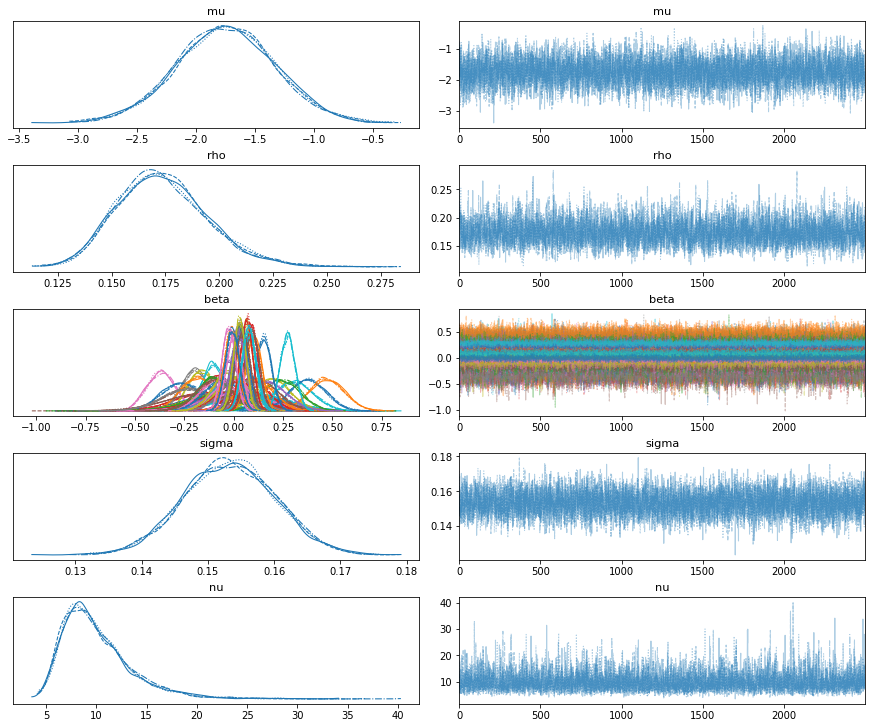

In [64]:
az.plot_trace(arviz_data, compact=True, var_names=["mu", "rho", "beta", "sigma", "nu"])

In [75]:
y_tilde = arviz_data.posterior_predictive.y_tilde.values.reshape(10000, -1)
residuals = y.values - np.mean(y_tilde, axis=0)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

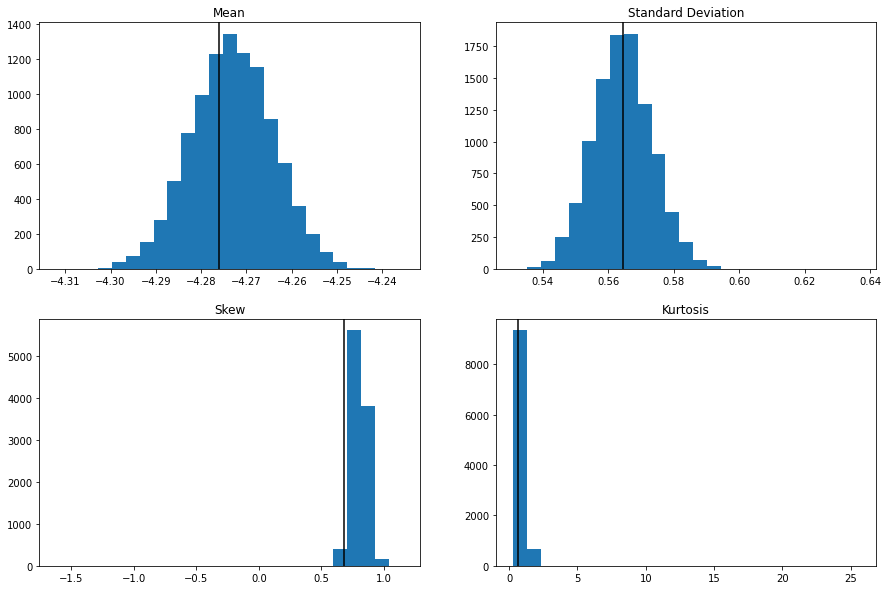

In [76]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=25)
axs[0, 0].axvline(np.mean(y), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=25)
axs[0, 1].axvline(np.std(y), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=25)
axs[1, 0].axvline(stats.skew(y), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=25)
axs[1, 1].axvline(stats.kurtosis(y), color='black')
axs[1, 1].set_title("Kurtosis")

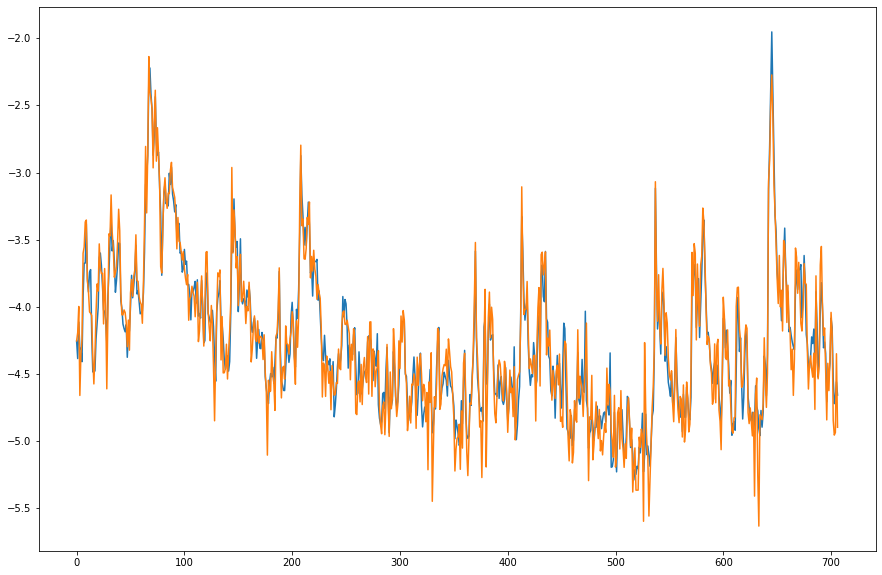

In [67]:
plt.plot(np.mean(y_tilde, axis=0))
plt.plot(y.values)

In [68]:
# 95% bounds exceedences
np.sum(y.values > np.percentile(y_tilde, 95, axis=0)) / len(y.values)

0.033946251768033946

In [69]:
# 5% bounds exceedences
np.sum(y.values < np.percentile(y_tilde, 5, axis=0)) / len(y.values)

0.042432814710042434

<AxesSubplot:xlabel='y / y_tilde'>

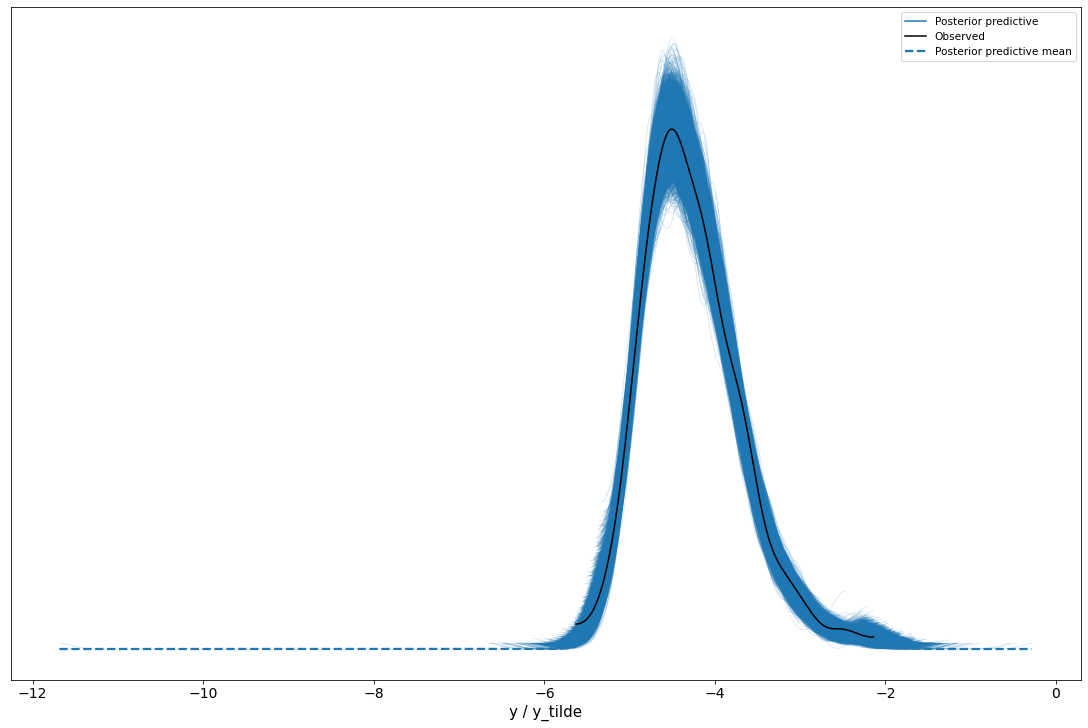

In [70]:
az.plot_ppc(arviz_data, data_pairs={"y": "y_tilde"})

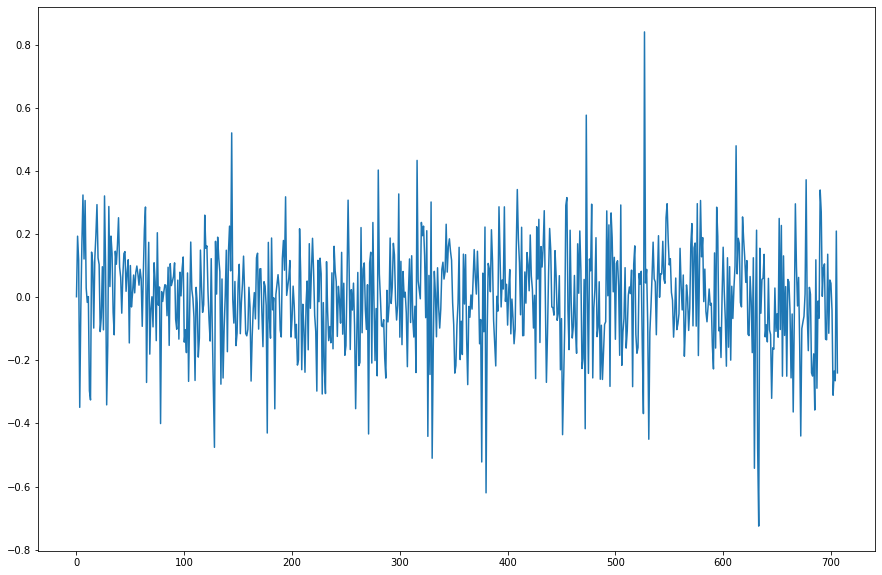

In [71]:
plt.plot(residuals)

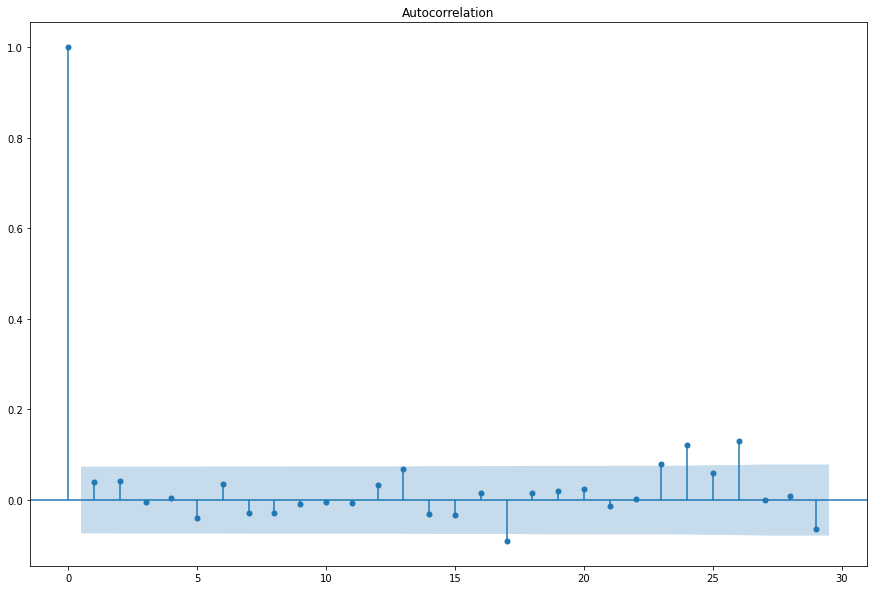

In [72]:
acf = sm.tsa.graphics.plot_acf(residuals)

In [73]:
values = []

for t in range(len(y)):
    ecdf = sm.distributions.empirical_distribution.ECDF(y_tilde[:, t])
    values.append(ecdf(y.iloc[t]))

In [74]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.03647666195190946, pvalue=0.29646976480606313)

In [59]:
class BayesLinearModel(BayesModel):
    def __init__(self):
        model_spec = """
            data {
                int N;  // Number of observations
                int p;  // Number of variables
                vector[N] y;  // Dependent variable
                matrix[N, p] x;  // Independent variables
                
                int N_tilde;  // Number of observations in OOS data
                matrix[N_tilde, p] x_tilde;  // OOS data
            }
            parameters {
                real mu;
                vector[p] beta;
                real<lower=0> rho;
                real<lower=0> sigma;
            }
            model {
                mu ~ normal(-5, 5);
                rho ~ normal(0, 1);
                beta ~ normal(0, rho);
                sigma ~ normal(0, 1);

                y ~ normal(mu + x * beta, sigma);
            }
            generated quantities {
                real y_tilde[N_tilde];
                y_tilde = normal_rng(mu + x_tilde * beta, sigma);
            }
            """
        with open("./stan_model/model.stan", "w") as file:
            file.write(model_spec)

        self.model = CmdStanModel(stan_file="./stan_model/model.stan")
    
    def fit(self, train_x, train_y, test_x, test_y):
        data = {"N": len(train_x),
                "p": len(train_x.columns),
                "y": train_y.values,
                "x": train_x.values,
                "N_tilde": len(test_x),
                "x_tilde": test_x.values}
        sample = self.model.sample(data=data, output_dir="./stan_model", iter_warmup=1000, iter_sampling=2500, inits=0)
        y_tilde = sample.stan_variable("y_tilde")
        predicted = pd.Series(np.mean(y_tilde, axis=0), index=test_y.index)
        residuals = test_y - predicted
        results = {"y_tilde": y_tilde, "predicted": predicted, "residuals": residuals}
        return results

In [60]:
model = BayesLinearModel()
# Minimum training samples equals 2 times number of parameters
cross_val = BayesTimeSeriesCrossVal(x, y, model, splits=5, min_samples=(len(x.columns) + 4) * 2)
results = cross_val.walk_forward_test()

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 0 complete.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 1 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 2 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 3 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


Split 4 complete.


In [61]:
y_tilde = np.concatenate([n["y_tilde"] for n in results], axis=1)
predicted = pd.concat([n["predicted"] for n in results])
residuals = pd.concat([n["residuals"] for n in results])
y_select = y.loc[predicted.index]

In [62]:
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

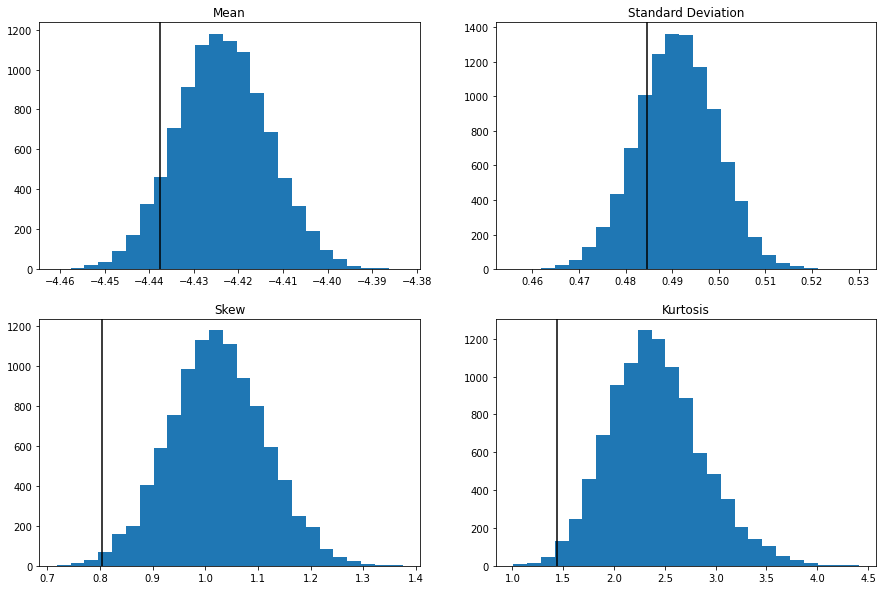

In [63]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=25)
axs[0, 0].axvline(np.mean(y_select), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=25)
axs[0, 1].axvline(np.std(y_select), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=25)
axs[1, 0].axvline(stats.skew(y_select), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=25)
axs[1, 1].axvline(stats.kurtosis(y_select), color='black')
axs[1, 1].set_title("Kurtosis")

<AxesSubplot:>

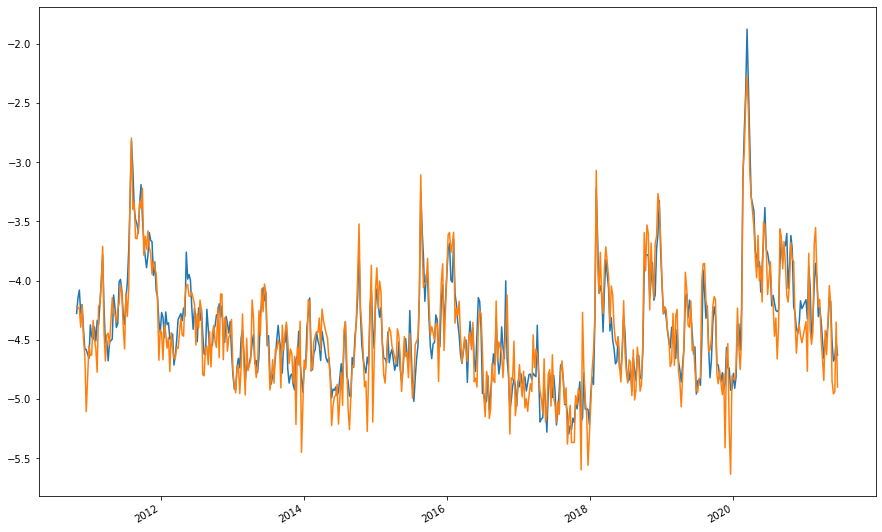

In [64]:
predicted.plot()
y_select.plot()

<AxesSubplot:>

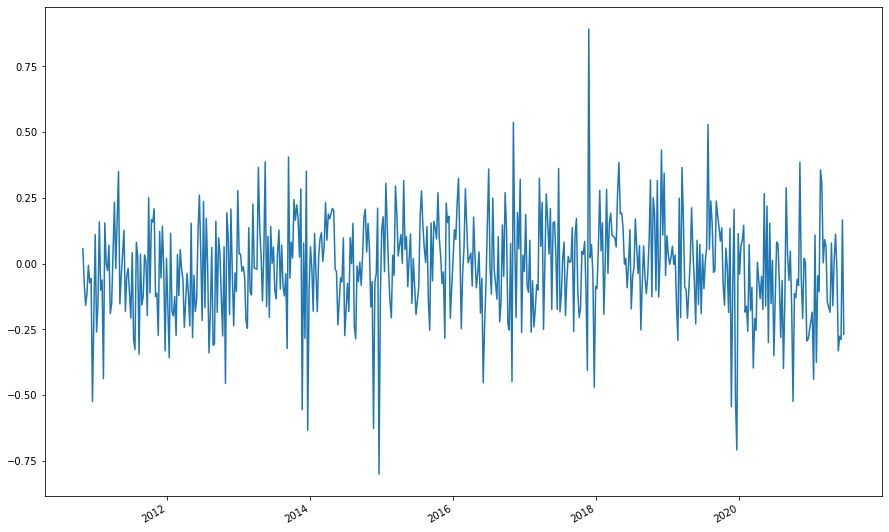

In [65]:
residuals.plot()

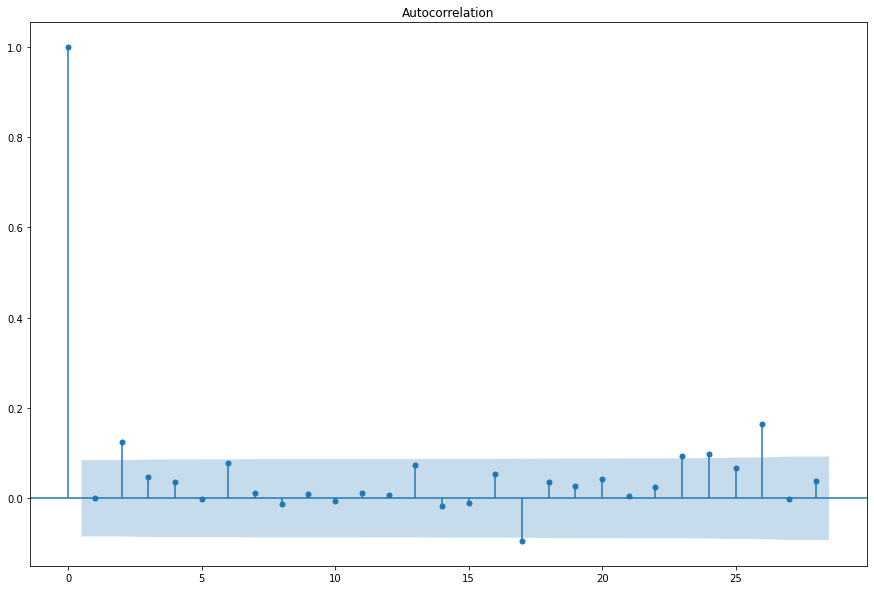

In [66]:
acf = sm.tsa.graphics.plot_acf(residuals)

In [67]:
# 95% bounds exceedences
np.sum(y_select.values > np.percentile(y_tilde, 95, axis=0)) / len(y_select)

0.048417132216014895

In [68]:
# 5% bounds exceedences
np.sum(y_select.values < np.percentile(y_tilde, 5, axis=0)) / len(y_select)

0.05772811918063315

In [69]:
values = []

for t in range(len(y_select)):
    ecdf = sm.distributions.empirical_distribution.ECDF(y_tilde[:, t])
    values.append(ecdf(y_select.iloc[t]))

In [70]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.04109906890130355, pvalue=0.31591336908794443)

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


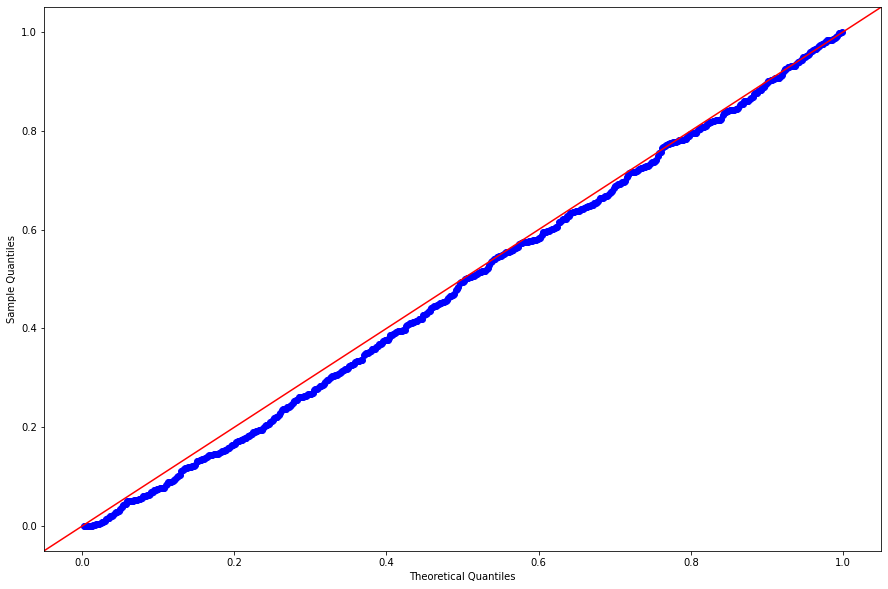

In [71]:
fig = sm.graphics.qqplot(np.array(values), dist=stats.uniform, line="45")